# Slip on Grass Example
This notebook contains a toy example model for reasoning about the probability of slipping and getting injured on grass in wet or dry states.
We first create the prior and conditional factors and then use these factors to construct a cluster graph. We then use this graph to perform
inference.

In [87]:
import sys
sys.path.append('../../')

In [88]:
from veroku.factors.categorical import Categorical, CategoricalTemplate
from veroku.cluster_graph import ClusterGraph
import numpy as np

In [89]:
all_factors = []

### 1. Factor Specification

#### 1.1 Priors

In [90]:
var_names = ['rain']
probs_table = {(0,):0.8, # no rain
               (1,):0.2} #    rain
var_cardinalities = [2]

rain_proir_pd = Categorical(probs_table=probs_table,
                            var_names=var_names,
                            cardinalities=var_cardinalities)
all_factors.append(rain_proir_pd)
rain_proir_pd.show()

['rain']   prob
(0,)   0.8
(1,)   0.2


False

In [91]:
var_names = ['sprinklers']
probs_table = {(0,):0.2, # no rain
               (1,):0.8} #    rain
var_cardinalities = [2]

sprinkers_proir_pd = Categorical(probs_table=probs_table,
                                 var_names=var_names,
                                 cardinalities=var_cardinalities)
all_factors.append(sprinkers_proir_pd)
sprinkers_proir_pd.show()

['sprinklers']   prob
(0,)   0.2
(1,)   0.8


In [92]:
rain_proir_pd.absorb(sprinkers_proir_pd).show()

['sprinklers', 'rain']   prob
(0, 0)   0.16000000000000003
(0, 1)   0.04000000000000001
(1, 0)   0.64
(1, 1)   0.16000000000000003


#### 1.2 Conditional Probability Distributions

In [93]:
var_names = ['rain', 'sprinklers', 'wet_grass']
probs_table = {(0,0,0):0.90, # grass dry given no rain and sprinklers off
               (0,0,1):0.10, # grass wet given "
               (0,1,0):0.05, # grass dry given no rain and sprinklers on
               (0,1,1):0.95, # grass wet given "
               (1,0,0):0.20, # grass dry given    rain and sprinklers off
               (1,0,1):0.80, # grass wet given "
               (1,1,0):0.00, # grass dry given    rain and sprinklers on
               (1,1,1):1.00} # grass wet given "
var_cardinalities = [2,2,2]

wet_grass_given_rain_and_sprinklers_cpd = Categorical(probs_table=probs_table,
                                                      var_names=var_names,
                                                      cardinalities=var_cardinalities)
all_factors.append(wet_grass_given_rain_and_sprinklers_cpd)
wet_grass_given_rain_and_sprinklers_cpd.show()

['rain', 'sprinklers', 'wet_grass']   prob
(0, 0, 0)   0.9
(0, 0, 1)   0.10000000000000002
(0, 1, 0)   0.05000000000000001
(0, 1, 1)   0.95
(1, 0, 0)   0.2
(1, 0, 1)   0.8
(1, 1, 0)   0.0
(1, 1, 1)   1.0


../../veroku/factors/categorical.py:54: RuntimeWarning: divide by zero encountered in log
  log_probs_table = {assignment: np.log(prob) for assignment, prob in probs_table.items()}


In [94]:
var_names = ['wet_grass','slip']
probs_table = {(0,0):0.2, #no slip given no wet_grass
               (0,1):0.8, #   slip given no wet_grass
               (1,0):0.6, #no slip given    wet_grass
               (1,1):0.4} #   slip given    wet_grass
var_cardinalities = [2,2]

slip_given_rain_cpd = Categorical(probs_table=probs_table,
                                  var_names=var_names,
                                  cardinalities=var_cardinalities)
all_factors.append(slip_given_rain_cpd)
slip_given_rain_cpd.show()

['wet_grass', 'slip']   prob
(0, 0)   0.2
(0, 1)   0.8
(1, 0)   0.6
(1, 1)   0.4


In [95]:
var_names = ['slip','injury']
probs_table = {(0,0):0.9, #no injury given no slip
               (0,1):0.1, #   injury given no slip
               (1,0):0.2, #no injury given    slip
               (1,1):0.8} #   injury given    slip
var_cardinalities = [2,2]

injury_given_slip_cpd = Categorical(probs_table=probs_table,
                                    var_names=var_names,
                                    cardinalities=var_cardinalities)
all_factors.append(injury_given_slip_cpd)
injury_given_slip_cpd.show()

['slip', 'injury']   prob
(0, 0)   0.9
(0, 1)   0.10000000000000002
(1, 0)   0.2
(1, 1)   0.8


### 2. Cluster Graph Inference

In [118]:
observed_evidence = {'rain':1}
marginal_vrs = ['slip']

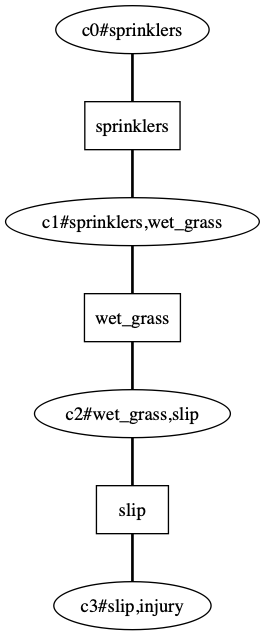

In [119]:
cluster_graph = ClusterGraph(all_factors, observed_evidence)
cluster_graph.debug = True
cluster_graph.show()

In [120]:
cluster_graph._clusters[1]._factor.show()

['sprinklers', 'wet_grass']   prob
(0, 0)   0.2
(0, 1)   0.8
(1, 0)   0.0
(1, 1)   1.0


In [121]:
cluster_graph.process_graph(tol=0.01, max_iter=10)
#cluster_graph.message_passing_log_df.head(10)
#cluster_graph.debug_passed_message_factors

Info: Starting iterative message passing.*


In [127]:
slip_posterior = cluster_graph.get_marginal(vrs=marginal_vrs)
slip_posterior.normalize().show()
#slip_posterior.show()

['slip']   prob
(0,)   0.584
(1,)   0.4159999999999999


### 3.0 Without a Cluster Graph
We can of course also compute marginal distributions without using a cluster graph, by simply multipying all the factors together, observing variables and reducing the joint distribution and then marginalising
out the variables that we are not interested in. While this approach works well enough for small examples, it is often intractable when the number of factors become large - since this causes a combinatoric increase in the parameters of the joint distribution.

In [131]:
joint_distribution = all_factors[0]
for factor in all_factors[1:]:
    joint_distribution = joint_distribution.absorb(factor)

reduced_distribution = joint_distribution.reduce(vrs=list(observed_evidence.keys()),
                                                 values=list(observed_evidence.values()))
marginal_posterior = fp_reduced.marginalize(vrs=marginal_vrs, keep=True)#.normalize()
marginal_posterior.normalize().show()

['slip']   prob
(0,)   0.584
(1,)   0.4160000000000001
